In [438]:
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import deeppavlov
from deeppavlov.dataset_readers.ontonotes_reader import OntonotesReader
from deeppavlov.models.preprocessors.capitalization import CapitalizationPreprocessor
from deeppavlov.models.embedders.glove_embedder import GloVeEmbedder

### Read data

In [439]:
reader = OntonotesReader()
dataset = reader.read(data_path='data/')
print(dataset.keys())
print('Num of train sentences: {}'.format(len(dataset['train'])))
print('Num of test sentences: {}'.format(len(dataset['test'])))

dict_keys(['train', 'valid', 'test'])
Num of train sentences: 75187
Num of test sentences: 9479


### Select few examples

In [440]:
n_examples = 10
np.random.seed(12)
indices = np.random.choice(len(dataset['train']), size=n_examples)
# indices = (10,20,30,40,50)
examples = [dataset['train'][i] for i in indices]
print(examples)

[(['Mr.', 'Bush', 'also', 'named', 'former', 'Cuban', 'refugee', 'Mel', 'Martinez', 'as', 'Secretary', 'of', 'Housing', 'and', 'Urban', 'Development', '.'], ['O', 'B-PERSON', 'O', 'O', 'O', 'B-NORP', 'O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O']), (['Currently', ',', 'the', 'degree', 'of', 'dependence', 'on', 'the', 'outside', 'of', 'China', "'s", 'economy', 'has', 'reached', '42', '%', ',', 'and', 'the', 'space', 'of', 'utilizing', 'overseas', 'markets', 'and', 'resources', 'is', 'in', 'the', 'process', 'of', 'expanding', ',', 'but', 'is', 'more', 'easily', 'subject', 'to', 'the', 'influences', 'of', 'the', 'international', 'environment', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GPE', 'O', 'O', 'O', 'O', 'B-PERCENT', 'I-PERCENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['But', 'whether', 'such', 'moves', 'can', 'win'

### Split tokens and tags

In [441]:
def split_tokens_tags(dataset: list):
    tokens = []
    tags = []
    for sample in dataset:
        tokens.append(sample[0])
        tags.append(sample[1])
    return tokens, tags

In [442]:
tokens_train,tags_train = split_tokens_tags(examples)
# print(tags_train)

### Elmo wrapper class

In [443]:
class ElmoEmbedder():
    def __init__(self):
        self.elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        self.sess = sess

    def get_tokens_embeddings(self, tokens_input: list, tokens_length:list=None):
        if not tokens_length:
            if isinstance(tokens_input[0], list):
                tokens_length = [len(seq) for seq in tokens_input]
            else:
                tokens_length = len(tokens_input)
        embeddings = self.elmo(
                        inputs={
                            "tokens": tokens_input,
                            "sequence_len": tokens_length
                        },
                        signature="tokens",
                        as_dict=True)["elmo"]
        embeddings = self.sess.run([embeddings])
        return embeddings[0]

### Utility functions

In [444]:
def tags2binary(tags, symb=True):
    tags = copy.deepcopy(tags)
    for seq in tags:
        for i in range(len(seq)):
            if symb:
                if seq[i] != 'O':
                    seq[i] = 'T'
            else:
                seq[i] = 1 if seq[i] != 'O' else 0
    return tags

In [445]:
def to_lower_case(tokens:list):
    tokens_lower = []
    for seq in tokens:
        tokens_lower.append([])
        for token in seq:
            tokens_lower[-1].append(token.lower())
    return tokens_lower

In [446]:
def get_tokens_len(tokens):
    if isinstance(tokens[0], str):
        tokens = [tokens]
    return [len(seq) for seq in tokens]

In [447]:
def add_padding(tokens:list):
    if isinstance(tokens[0], str):
        return tokens, len(tokens)
    elif isinstance(tokens[0], list):
        tokens = copy.deepcopy(tokens)
        max_len = 0
        for seq in tokens:
            if len(seq) > max_len:
                max_len = len(seq)
        for seq in tokens:
            i = len(seq)
            while i < max_len:
                seq.append('')
                i += 1
        return tokens
    else:
        raise Exception('tokens should be either list of strings or list of lists of strings')

In [448]:
def flatten_list(ar: list):
    flat = []
    for sublist in ar:
        flat += sublist
    return flat

In [449]:
def select_list_elements(ar: list, indices: list):
    return [ar[i] for i in indices]

In [450]:
tokens_train_flat = flatten_list(tokens_train)
tags_train_flat = flatten_list(tags_train)
ne_train_count = 0
for tag in tags_train_flat:
    if tag == 'T':
        ne_train_count += 1
print('# of tokens in support set {}'.format(len(tokens_train_flat)))
print('# of named entities in support set {}'.format(ne_train_count))

# of tokens in support set 270
# of named entities in support set 0


### Transform NER to binary classification

In [451]:
tags_train = tags2binary(tags_train)

### Main embedder

In [452]:
class CompositeEmbedder():
    def __init__(self, use_elmo=True, elmo_scale=1., use_cap_feat=False, use_glove=False):
        self.use_elmo = use_elmo
        self.elmo_scale = elmo_scale
        self.use_cap_feat = use_cap_feat
        self.use_glove = use_glove
        if self.use_elmo:
            self.elmo = ElmoEmbedder()
        if self.use_cap_feat:
            self.cap_prep = CapitalizationPreprocessor()
        if self.use_glove:
            self.glove = GloVeEmbedder('embeddings/glove.6B/glove.6B.100d.txt', pad_zero=True)
        
    def embed(self, tokens: list):
        if isinstance(tokens[0], str):
            tokens = [tokens]
        # Get ELMo embeddings
        if self.use_elmo:
            tokens_input = add_padding(tokens)
            tokens_length = get_tokens_len(tokens)
            embeddings = self.elmo.get_tokens_embeddings(tokens_input, tokens_length)
            embeddings *= self.elmo_scale
            embed_size = embeddings.shape[-1]
#             print(embeddings.shape)
#             print(embed_size)

        # Use capitalization features
        if self.use_cap_feat:
#             print('Use capitalization features')
            cap_features = self.cap_prep(tokens)
    #         print(cap_features)
#             print(cap_features.shape)
            embeddings = np.concatenate((embeddings, cap_features), axis=2)
            embed_size = embeddings.shape[-1]
#             print(embeddings.shape)

        # Use GloVe embeddings
        if self.use_glove:
#             print('Use GloVe')
            
            glove_embed = self.glove(to_lower_case(tokens))
            glove_embed = np.array(glove_embed)
            if not self.use_elmo:
                embeddings = glove_embed
            else: 
                embeddings = np.concatenate((embeddings, glove_embed), axis=2)
            embed_size = embeddings.shape[-1]
#             print(embeddings.shape)
        
        return embeddings

### Calculate similarity of embedding vector to some prototype (centroid or smth)

In [453]:
def calc_sim(token_vec, support_vec)->dict:
    sim = {}
    sim['euc_dist'] = np.linalg.norm(token_vec - support_vec)
    sim['dot_prod'] = np.dot(token_vec, support_vec)
    sim['cosine'] = np.dot(token_vec, support_vec)/(np.linalg.norm(token_vec)*np.linalg.norm(support_vec)) if np.linalg.norm(support_vec) != 0 else 0
    return sim

In [454]:
def calc_sim_batch(tokens: list, embeddings: np.ndarray, support_vec: np.ndarray)->list:
    sim_list = []
    tokens_length = get_tokens_len(tokens)
    for i in range(len(tokens_length)):
        sim_list.append([])
        for j in range(tokens_length[i]):
            token_vec = embeddings[i,j,:]
            sim_list[i].append(calc_sim(token_vec, support_vec))
    return sim_list

In [455]:
def flatten_sim(sim_list):
    sims_flat = {'euc_dist': [], 'dot_prod': [], 'cosine': []}
    for i in range(len(sim_list)):
        for j in range(len(sim_list[i])):
            for sim_type in ['euc_dist', 'dot_prod', 'cosine']:
                sims_flat[sim_type].append(sim_list[i][j][sim_type])
    for sim_type in ['euc_dist', 'dot_prod', 'cosine']:
        sims_flat[sim_type] = np.array(sims_flat[sim_type])
    return sims_flat

### Calculate centroid for named entities embedding vectors

In [456]:
def calc_ne_centroid_vec(tokens: list, tags: list, embeddings: np.ndarray=None, embedder: CompositeEmbedder=None):

    # Calculate embeddings
    if embedder != None:
        embeddings = embedder.embed(tokens)

    # Calculate average vector for ne-tags
    embed_size = embeddings.shape[-1]
    ne_prototype = np.zeros((embed_size,))
    tokens_length = get_tokens_len(tokens)
#     embeddings_ne = []
    tags_bin = np.array(flatten_list(tags2binary(tags, symb=False)))
    print(tags_bin)
    n_ne_tags = np.sum(tags_bin == 1)
    embeddings_flat_ne = np.zeros((n_ne_tags, embed_size))
#     print(n_ne_tags)
    n_ne_tags = 0
    k = 0
    for i in range(len(tokens_length)):
        for j in range(tokens_length[i]):
            if tags[i][j] == 'T':
                ne_prototype += embeddings[i,j,:].reshape((embed_size,))
                embeddings_flat_ne[k,:] = embeddings[i,j,:]
                k += 1   # TODO: Change this to some better approach
#                 embeddings_ne.append(embeddings[i,j,:])
                n_ne_tags += 1
#     print(n_ne_tags)
    if n_ne_tags != 0:
        ne_prototype /= n_ne_tags
#     print('ne mean vector: {}'.format(ne_prototype))
    
    # Calculate similarities
    sim_list = calc_sim_batch(tokens, embeddings, ne_prototype)

    return ne_prototype, sim_list, embeddings, embeddings_flat_ne

### Calculate similarities of some test tokens to NE prototype

In [457]:
def calc_sim_to_ne_prototype(tokens: list, ne_prototype: np.ndarray, embeddings: np.ndarray=None, embedder: CompositeEmbedder=None):
    if isinstance(tokens[0], str):
        tokens = [tokens]
    
    tokens_length = get_tokens_len(tokens)
    
    # Calculate embeddings
    if embedder != None:
        embeddings = embedder.embed(tokens)
    
    # Calculate similarities
    sim_list = calc_sim_batch(tokens, embeddings, ne_prototype)
    
    return sim_list, embeddings

In [458]:
def calc_sim_to_ne_nearest(tokens: list, ne_support_embeddings: np.ndarray, embeddings: np.ndarray=None, embedder: CompositeEmbedder=None):
    if isinstance(tokens[0], str):
        tokens = [tokens]
    
    tokens_length = get_tokens_len(tokens)
    
    # Calculate embeddings
    if embedder != None:
        embeddings = embedder.embed(tokens)
    
    # Calculate similarities
    n_supports = ne_support_embeddings.shape[0]
    sim_list = []
    tokens_length = get_tokens_len(tokens)
    for i in range(len(tokens_length)):
        sim_list.append([])
        for j in range(tokens_length[i]):
            token_vec = embeddings[i,j,:]
            sim_token = []
            for k in range(n_supports):
                sim_token.append(calc_sim(token_vec, ne_support_embeddings[k, :])['cosine'])
            sim_list[i].append({'cosine': np.max(np.array(sim_token)), 'euc_dist': 0, 'dot_prod': 0})
            
    return sim_list, embeddings
    

In [459]:
embedder = CompositeEmbedder(use_elmo=True, elmo_scale=1, use_cap_feat=True, use_glove=True)

INFO:tensorflow:Initialize variable module_7/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling


2018-08-03 19:31:42.888 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling


INFO:tensorflow:Initialize variable module_7/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights


2018-08-03 19:31:42.894 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights


INFO:tensorflow:Initialize variable module_7/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0


2018-08-03 19:31:42.902 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0


INFO:tensorflow:Initialize variable module_7/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_1


2018-08-03 19:31:42.909 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_1


INFO:tensorflow:Initialize variable module_7/bilm/CNN/W_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_2


2018-08-03 19:31:42.917 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN/W_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_2


INFO:tensorflow:Initialize variable module_7/bilm/CNN/W_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_3


2018-08-03 19:31:42.923 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN/W_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_3


INFO:tensorflow:Initialize variable module_7/bilm/CNN/W_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_4


2018-08-03 19:31:42.929 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN/W_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_4


INFO:tensorflow:Initialize variable module_7/bilm/CNN/W_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_5


2018-08-03 19:31:42.934 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN/W_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_5


INFO:tensorflow:Initialize variable module_7/bilm/CNN/W_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_6


2018-08-03 19:31:42.940 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN/W_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_6


INFO:tensorflow:Initialize variable module_7/bilm/CNN/b_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_0


2018-08-03 19:31:42.945 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN/b_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_0


INFO:tensorflow:Initialize variable module_7/bilm/CNN/b_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_1


2018-08-03 19:31:42.951 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN/b_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_1


INFO:tensorflow:Initialize variable module_7/bilm/CNN/b_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_2


2018-08-03 19:31:42.962 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN/b_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_2


INFO:tensorflow:Initialize variable module_7/bilm/CNN/b_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_3


2018-08-03 19:31:42.968 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN/b_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_3


INFO:tensorflow:Initialize variable module_7/bilm/CNN/b_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_4


2018-08-03 19:31:42.974 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN/b_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_4


INFO:tensorflow:Initialize variable module_7/bilm/CNN/b_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_5


2018-08-03 19:31:42.982 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN/b_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_5


INFO:tensorflow:Initialize variable module_7/bilm/CNN/b_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_6


2018-08-03 19:31:42.989 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN/b_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_6


INFO:tensorflow:Initialize variable module_7/bilm/CNN_high_0/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_carry


2018-08-03 19:31:42.997 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN_high_0/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_carry


INFO:tensorflow:Initialize variable module_7/bilm/CNN_high_0/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_transform


2018-08-03 19:31:43.5 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN_high_0/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_transform


INFO:tensorflow:Initialize variable module_7/bilm/CNN_high_0/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_carry


2018-08-03 19:31:43.12 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN_high_0/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_carry


INFO:tensorflow:Initialize variable module_7/bilm/CNN_high_0/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_transform


2018-08-03 19:31:43.19 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN_high_0/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_transform


INFO:tensorflow:Initialize variable module_7/bilm/CNN_high_1/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_carry


2018-08-03 19:31:43.25 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN_high_1/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_carry


INFO:tensorflow:Initialize variable module_7/bilm/CNN_high_1/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_transform


2018-08-03 19:31:43.31 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN_high_1/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_transform


INFO:tensorflow:Initialize variable module_7/bilm/CNN_high_1/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_carry


2018-08-03 19:31:43.38 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN_high_1/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_carry


INFO:tensorflow:Initialize variable module_7/bilm/CNN_high_1/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_transform


2018-08-03 19:31:43.44 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN_high_1/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_transform


INFO:tensorflow:Initialize variable module_7/bilm/CNN_proj/W_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/W_proj


2018-08-03 19:31:43.52 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN_proj/W_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/W_proj


INFO:tensorflow:Initialize variable module_7/bilm/CNN_proj/b_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/b_proj


2018-08-03 19:31:43.58 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/CNN_proj/b_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/b_proj


INFO:tensorflow:Initialize variable module_7/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


2018-08-03 19:31:43.64 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_7/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


2018-08-03 19:31:43.70 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_7/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


2018-08-03 19:31:43.77 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_7/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


2018-08-03 19:31:43.84 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_7/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


2018-08-03 19:31:43.92 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_7/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


2018-08-03 19:31:43.98 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_7/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


2018-08-03 19:31:43.105 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_7/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


2018-08-03 19:31:43.113 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_7/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


2018-08-03 19:31:43.119 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_7/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


2018-08-03 19:31:43.125 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_7/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


2018-08-03 19:31:43.131 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_7/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


2018-08-03 19:31:43.137 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_7/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed


2018-08-03 19:31:43.144 INFO in 'tensorflow'['tf_logging'] at line 116: Initialize variable module_7/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed
2018-08-03 19:31:45.922 INFO in 'deeppavlov.models.embedders.glove_embedder'['glove_embedder'] at line 60: [loading embeddings from `/home/kostrovskiy/prog/AI/NLP/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt`]
2018-08-03 19:31:45.923 INFO in 'gensim.models.keyedvectors'['keyedvectors'] at line 204: loading projection weights from /home/kostrovskiy/prog/AI/NLP/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt
2018-08-03 19:31:45.924 DEBUG in 'smart_open.smart_open_lib'['smart_open_lib'] at line 176: {'kw': {}, 'mode': 'rb', 'uri': '/home/kostrovskiy/prog/AI/NLP/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt'}
2018-08-03 19:32:17.42 INFO in 'gensim.models.keyedvectors'['keyedvectors'] at line 266: loaded (400000, 100) mat

### Calculate NE centroid for given examples

In [460]:
ne_prototype, _, _, ne_support_embeddings = calc_ne_centroid_vec(tokens_train, tags_train, embedder=embedder)
print(embeddings_ne.shape)

[0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
(21, 1128)


### Select some unlabeled examples from test set and estimate similarity to named entity for each token

In [461]:
n_test_sentences = 100
np.random.seed(44)
indices_test = np.random.choice(len(dataset['test']), size=n_test_sentences)
test_sentences = select_list_elements(dataset['test'], indices_test)
tokens_test,tags_test = split_tokens_tags(test_sentences)
# print(tokens_test)
# print(tags_test)

In [462]:
tags_test_bin_flat = np.array(flatten_list(tags2binary(tags_test, symb=False)))

In [463]:
METHOD = 'NEAREST' #'PROTOTYPE'
if METHOD == 'PROTOTYPE':
    sim_list_test, _ = calc_sim_to_ne_prototype(tokens_test, ne_prototype, embedder=embedder)
elif METHOD == 'NEAREST':
    sim_list_test, _ = calc_sim_to_ne_nearest(tokens_test, ne_support_embeddings, embedder=embedder)

In [464]:
print(sim_list_test)

[[{'cosine': 0.4325510028836278, 'euc_dist': 0, 'dot_prod': 0}, {'cosine': 0.7209052843850978, 'euc_dist': 0, 'dot_prod': 0}, {'cosine': 0.21824797128575416, 'euc_dist': 0, 'dot_prod': 0}, {'cosine': 0.25705266410861377, 'euc_dist': 0, 'dot_prod': 0}, {'cosine': 0.21273789811657423, 'euc_dist': 0, 'dot_prod': 0}, {'cosine': 0.22137689716216594, 'euc_dist': 0, 'dot_prod': 0}, {'cosine': 0.21704746342338066, 'euc_dist': 0, 'dot_prod': 0}, {'cosine': 0.5658266076639362, 'euc_dist': 0, 'dot_prod': 0}, {'cosine': 0.31042038617663203, 'euc_dist': 0, 'dot_prod': 0}, {'cosine': 0.4284966144265089, 'euc_dist': 0, 'dot_prod': 0}, {'cosine': 0.1967562444599861, 'euc_dist': 0, 'dot_prod': 0}, {'cosine': 0.17566905517123624, 'euc_dist': 0, 'dot_prod': 0}, {'cosine': 0.2568370740132381, 'euc_dist': 0, 'dot_prod': 0}, {'cosine': 0.29375188633579985, 'euc_dist': 0, 'dot_prod': 0}, {'cosine': 0.24324917191766618, 'euc_dist': 0, 'dot_prod': 0}], [{'cosine': 0.2311951819388959, 'euc_dist': 0, 'dot_prod':

### Group similarities with tokens

In [465]:
def zip_tokens_sim(tokens: list, sim_list: list, sim_type='cosine'):
    tokens_sim = []
    for i in range(len(tokens)):
        tokens_sim.append([])
        for j in range(len(tokens[i])):
            tokens_sim[-1].append((tokens[i][j], sim_list[i][j][sim_type]))
    return tokens_sim

In [466]:
tokens_test_sim = zip_tokens_sim(tokens_test, sim_list_test)

### Print test sentences with NE similarities estimation

In [467]:
def decorate_ne_token(token, tag):
    if tag == 'T':
        token = '[[' + token + ']]'
    return token
def format_labeled_examples(tokens_input: list, tags_input: list):
    s = '+++++++++ Input examples +++++++++\n\n'
    for i in range(len(tokens_input)):
        for j in range(len(tokens_input[i])):
            s += decorate_ne_token(tokens_input[i][j], tags_input[i][j]) + ' '
        s += '\n\n'
    return s

In [468]:
def format_inference_results(tokens_sim: list):
    s = '+++++++++ Tests +++++++++\n\n'
    for seq in tokens_sim:
        for token, sim in seq:
            s += '{}[{:.3f}]'.format(token, sim)
            s += ' '
        s += '\n\n'
    return s

In [469]:
text = ''
text += format_labeled_examples(tokens_train, tags_train)
text += format_inference_results(tokens_test_sim)
print(text)

+++++++++ Input examples +++++++++

Mr. [[Bush]] also named former [[Cuban]] refugee [[Mel]] [[Martinez]] as Secretary of [[Housing]] [[and]] [[Urban]] [[Development]] . 

Currently , the degree of dependence on the outside of [[China]] 's economy has reached [[42]] [[%]] , and the space of utilizing overseas markets and resources is in the process of expanding , but is more easily subject to the influences of the international environment . 

But whether such moves can win back the confidence of [[East]] [[Germans]] , who have taken to the streets by the [[thousands]] in [[recent]] [[weeks]] to demand democratic changes , depends largely on whether they feel they can trust Mr. [[Krenz]] . 

[[Andy]] [[Cairns]] 

I totally insist on it . 

kind of threw me off 

We have had the most truthful , constructive , profound negotiations ever to be held since this phase in the peace talks has started . 

How much of the ancient form of the festival survives , and what new elements have been ad

### Visualize similarities tokens to NE

In [470]:
from IPython.core.display import display, HTML

In [471]:
def get_color(red=0, green=255, blue=0):
    return {'r': red, 'g': green, 'b': blue}

def get_rgba_str(color, alpha=1):
    return 'rgba({},{},{},{})'.format(color['r'], color['g'], color['b'], alpha)

def get_token_span_str(token, color, cf=1):
    return '<span style="padding: 0.15em; margin-right: 4px; border-radius: 0.25em; background: {};">{}</span>'.format(get_rgba_str(color, alpha=cf), token)

def wrap_with_style(html):
    return '<div style="line-height: 1.5em;">{:s}</div>'.format(html)

In [472]:
bg_color = get_color(red=0, green=255, blue=0)
display(HTML(get_token_span_str('token', bg_color, cf=0.7)))

In [473]:
sim_flat = flatten_sim(sim_list_test)
sim_min = np.min(sim_flat['cosine'])
sim_max = np.max(sim_flat['cosine'])

In [474]:
def sim_transform(sim, T=0.5):
    # similarity transformation for better visualization
    return (np.exp(sim/T) - np.exp(sim_min/T))/(np.exp(sim_max/T) - np.exp(sim_min/T))
def sim_transform_lin(sim):
    # similarity transformation for better visualization
    return (sim - sim_min)/(sim_max - sim_min)

In [475]:
def get_colored_results_html(tokens_sim: list, color):
    s = '<h3 style="margin-bottom:0.3em;">Visualization of tokens to NE similarities on test set:</h3>'
    for seq in tokens_sim:
        for token, sim in seq:
            s += get_token_span_str(token, color, cf=sim_transform(sim))
#             s += ' '
        s += '<br/><br/>'
    return wrap_with_style(s)

In [476]:
display(HTML(get_colored_results_html(tokens_test_sim, bg_color)))

### Plot histograms of test similarities

In [477]:
sim_flat = np.array(flatten_sim(sim_list_test)['cosine'])
sim_test_words = sim_flat[tags_test_bin_flat == 0]
sim_test_ne = sim_flat[tags_test_bin_flat == 1]
print(sim_test_words.shape)
print(sim_test_ne.shape)

(1674,)
(253,)


Text(0.5,1,'Histograms')

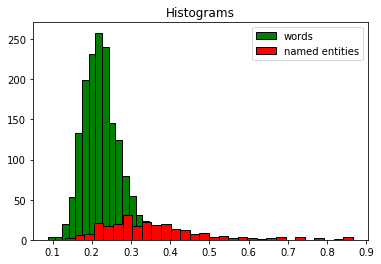

In [482]:
plt.hist(sim_test_words, color = 'green', edgecolor = 'black',
         bins = 30, label='words')
plt.hist(sim_test_ne, color = 'red', edgecolor = 'black',
         bins = 30, label='named entities')
plt.legend()
plt.title('Histograms')

### Plot probability densities

Text(0.5,1,'Probability densities')

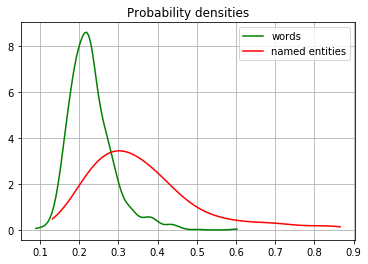

In [483]:
# https://stackoverflow.com/questions/15415455/plotting-probability-density-function-by-sample-with-matplotlib
from scipy.stats.kde import gaussian_kde
from numpy import linspace
kde_words = gaussian_kde( sim_test_words )
dist_space_words = linspace( min(sim_test_words), max(sim_test_words), 100 )
kde_ne = gaussian_kde( sim_test_ne )
dist_space_ne = linspace( min(sim_test_ne), max(sim_test_ne), 100 )
plt.plot( dist_space_words, kde_words(dist_space_words), color='green', label='words' )
plt.plot( dist_space_ne, kde_ne(dist_space_ne), color='red',  label='named entities' )
plt.legend()
plt.grid()
plt.title('Probability densities')